In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

file_path = 'dji.csv'
df = pd.read_csv(file_path)

print("\nInitial Data Overview:")
print(df.head())



Initial Data Overview:
         Date          Open          High           Low         Close  \
0  2007-01-03  12459.540039  12580.349609  12404.820312  12474.519531   
1  2007-01-04  12473.160156  12510.410156  12403.860352  12480.690430   
2  2007-01-05  12480.049805  12480.129883  12365.410156  12398.009766   
3  2007-01-08  12392.009766  12445.919922  12337.370117  12423.490234   
4  2007-01-09  12424.769531  12466.429688  12369.169922  12416.599609   

      Adj Close     Volume  
0  12474.519531  327200000  
1  12480.690430  259060000  
2  12398.009766  235220000  
3  12423.490234  223500000  
4  12416.599609  225190000  


In [2]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)

df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

df.fillna(method='ffill', inplace=True)

df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

df['BB_Middle'] = df['Close'].rolling(window=20).mean()
df['BB_Upper'] = df['BB_Middle'] + 2 * df['Close'].rolling(window=20).std()
df['BB_Lower'] = df['BB_Middle'] - 2 * df['Close'].rolling(window=20).std()

ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

def calculate_rsi(data, window=14):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0).rolling(window=window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

df['RSI'] = calculate_rsi(df['Close'])

df.dropna(inplace=True)

print("\nPreprocessed Data Overview:")
print(df.head())



Preprocessed Data Overview:
         Date          Open          High           Low         Close  \
19 2007-01-31  12520.030273  12657.019531  12505.200195  12621.690430   
20 2007-02-01  12617.200195  12682.570312  12616.080078  12673.679688   
21 2007-02-02  12673.839844  12683.929688  12638.349609  12653.490234   
22 2007-02-05  12653.410156  12681.209961  12629.860352  12661.740234   
23 2007-02-06  12661.660156  12680.570312  12633.940430  12666.309570   

       Volume           MA5          MA10          MA20     BB_Middle  \
19  258410000  12525.071875  12539.154883  12512.890967  12512.890967   
20  235130000  12559.295898  12549.729883  12522.848975  12522.848975   
21  203610000  12592.590039  12558.525879  12531.488965  12531.488965   
22  204140000  12626.782031  12576.983887  12544.675488  12544.675488   
23  201010000  12655.382031  12590.234863  12556.816455  12556.816455   

        BB_Upper      BB_Lower       MACD  Signal_Line        RSI  
19  12643.807220  12381.9

C:\Users\Laksh Gupta\AppData\Local\Temp\ipykernel_16700\2150424415.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


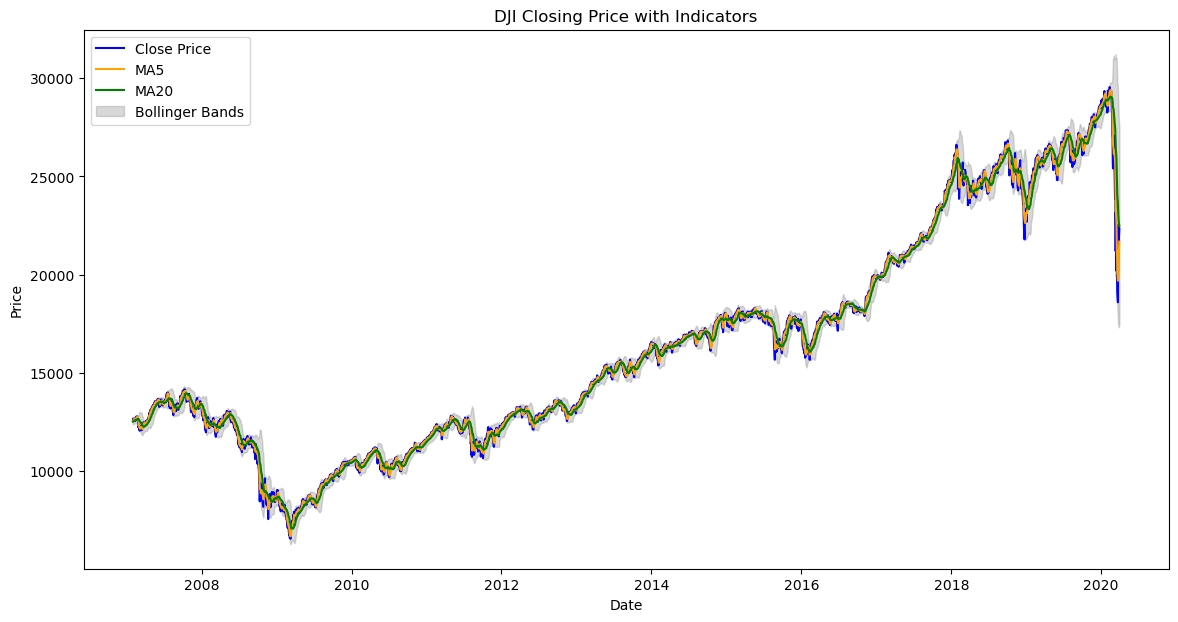

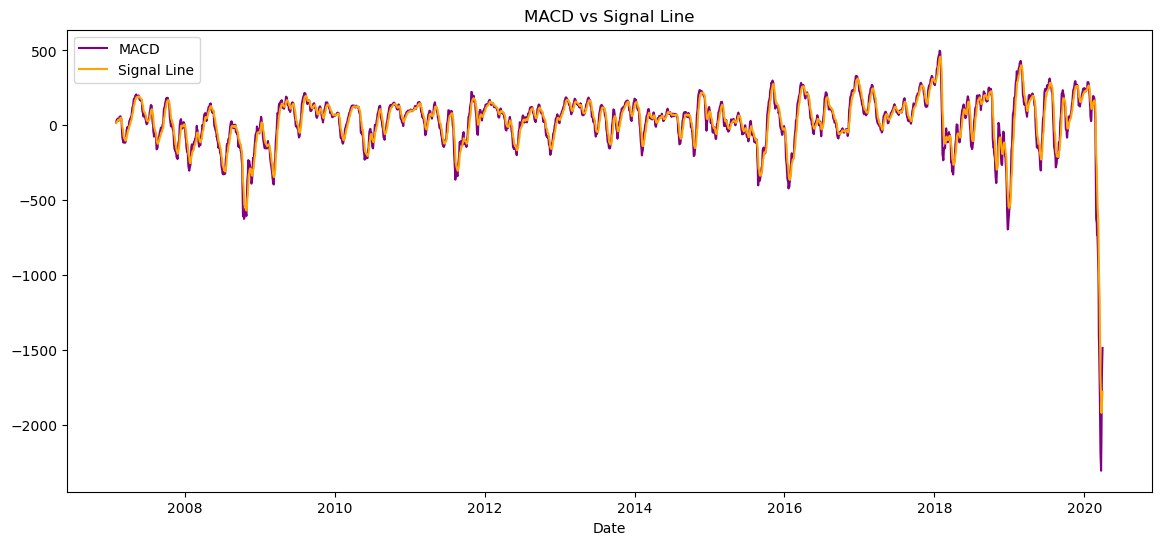

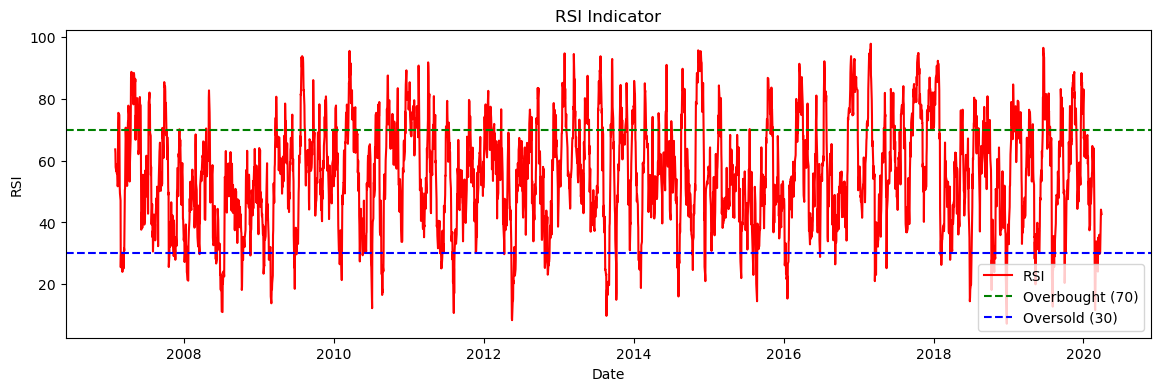

In [3]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.plot(df['Date'], df['MA5'], label='MA5', color='orange')
plt.plot(df['Date'], df['MA20'], label='MA20', color='green')
plt.fill_between(df['Date'], df['BB_Upper'], df['BB_Lower'], color='gray', alpha=0.3, label='Bollinger Bands')
plt.title('DJI Closing Price with Indicators')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['MACD'], label='MACD', color='purple')
plt.plot(df['Date'], df['Signal_Line'], label='Signal Line', color='orange')
plt.title('MACD vs Signal Line')
plt.xlabel('Date')
plt.legend()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(df['Date'], df['RSI'], label='RSI', color='red')
plt.axhline(70, color='green', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='blue', linestyle='--', label='Oversold (30)')
plt.title('RSI Indicator')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()


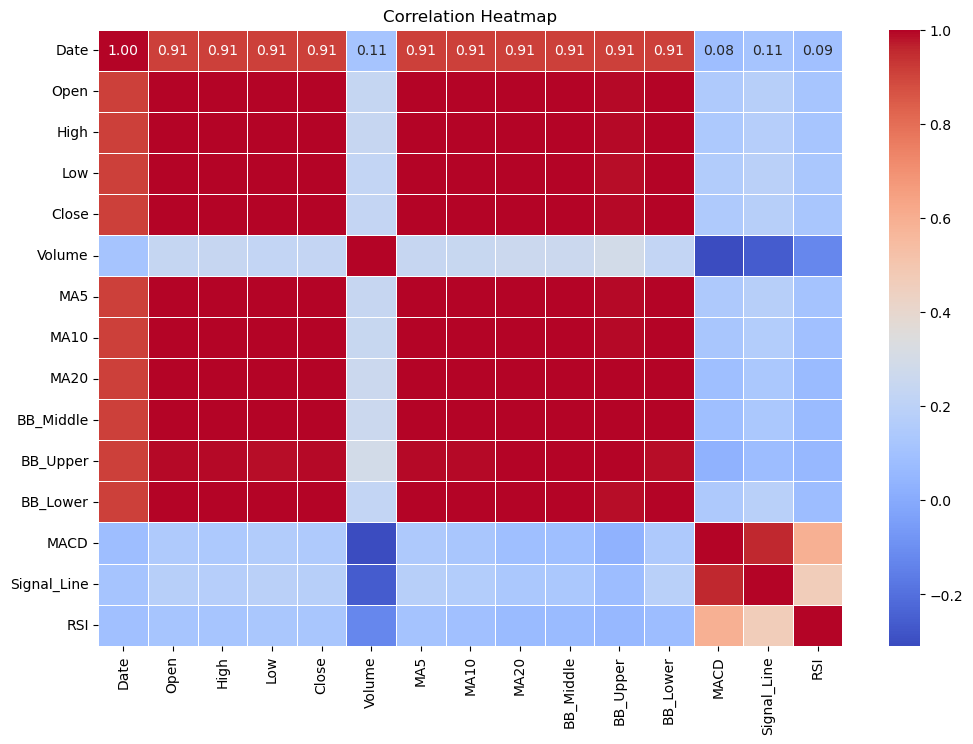

In [4]:
corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [5]:
features = ['MA5', 'MA10', 'MA20', 'BB_Upper', 'BB_Lower', 'MACD', 'Signal_Line', 'RSI']
target = 'Close'

X = df[features]
y = df[target]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [7]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("\nLinear Regression Metrics:")
print(f'MSE: {mse_lr}, MAE: {mae_lr}, R2 Score: {r2_lr}')



Linear Regression Metrics:
MSE: 10604.611093813532, MAE: 60.8513285452998, R2 Score: 0.9996356769124185


In [8]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Metrics:")
print(f'MSE: {mse_xgb}, MAE: {mae_xgb}, R2 Score: {r2_xgb}')



XGBoost Metrics:
MSE: 27480.23188478339, MAE: 98.93249272365196, R2 Score: 0.9990559122970987


In [9]:
X_train_nn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_nn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_nn.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_nn, y_train, epochs=50, batch_size=32, validation_data=(X_test_nn, y_test))

y_pred_lstm = lstm_model.predict(X_test_nn)

mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

print("\nLSTM Metrics:")
print(f'MSE: {mse_lstm}, MAE: {mae_lstm}, R2 Score: {r2_lstm}')


C:\Users\Laksh Gupta\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 303156064.0000 - val_loss: 283038304.0000
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 297228800.0000 - val_loss: 282880928.0000
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 294293696.0000 - val_loss: 282735456.0000
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 303948896.0000 - val_loss: 282593568.0000
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 297071456.0000 - val_loss: 282454368.0000
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 300786112.0000 - val_loss: 282316128.0000
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 292853920.0000 - val_loss: 282179040.0000
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 300811616.0000 - val_loss: 282042240.0000
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 291914432.0000 - val_loss: 281906432.0000
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 296753184.0000 - val_loss: 281

In [10]:
metrics = pd.DataFrame({
    "Model": ['Linear Regression', 'XGBoost', 'LSTM'],
    "MSE": [mse_lr, mse_xgb, mse_lstm],
    "MAE": [mae_lr, mae_xgb, mae_lstm],
    "R2 Score": [r2_lr, r2_xgb, r2_lstm]
})

print("\nModel Performance Comparison:")
print(metrics)



Model Performance Comparison:
               Model           MSE           MAE  R2 Score
0  Linear Regression  1.060461e+04     60.851329  0.999636
1            XGBoost  2.748023e+04     98.932493  0.999056
2               LSTM  2.764441e+08  15726.932369 -8.497281


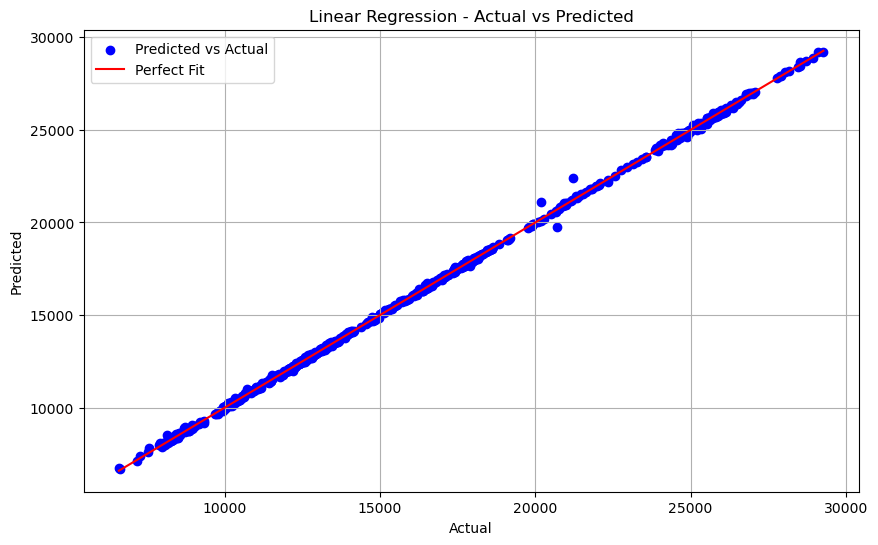

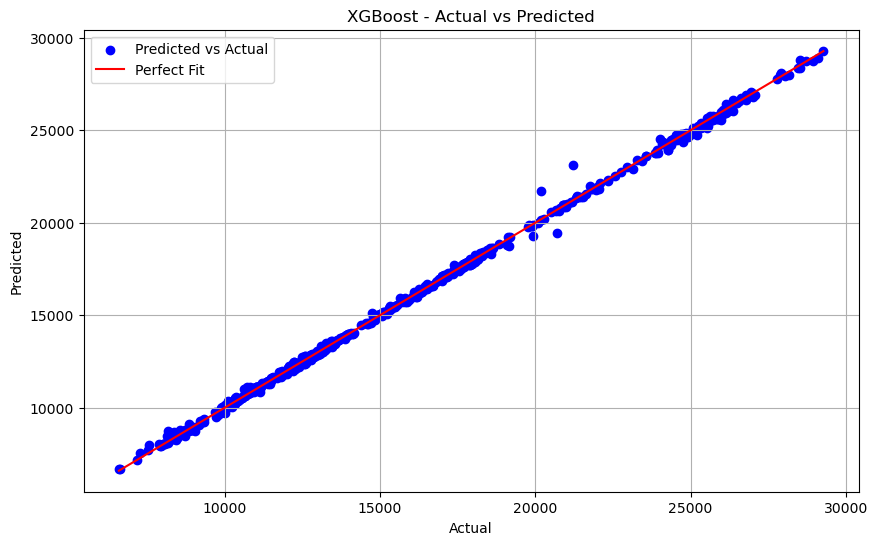

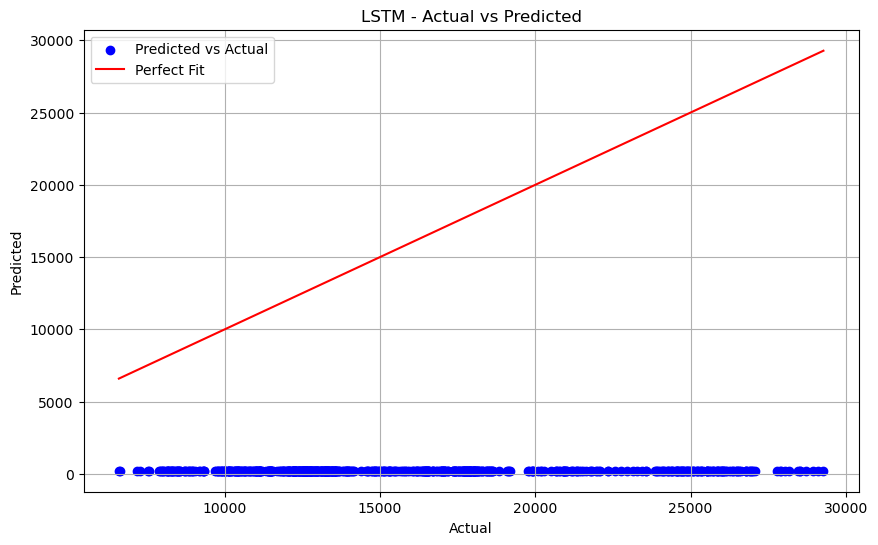

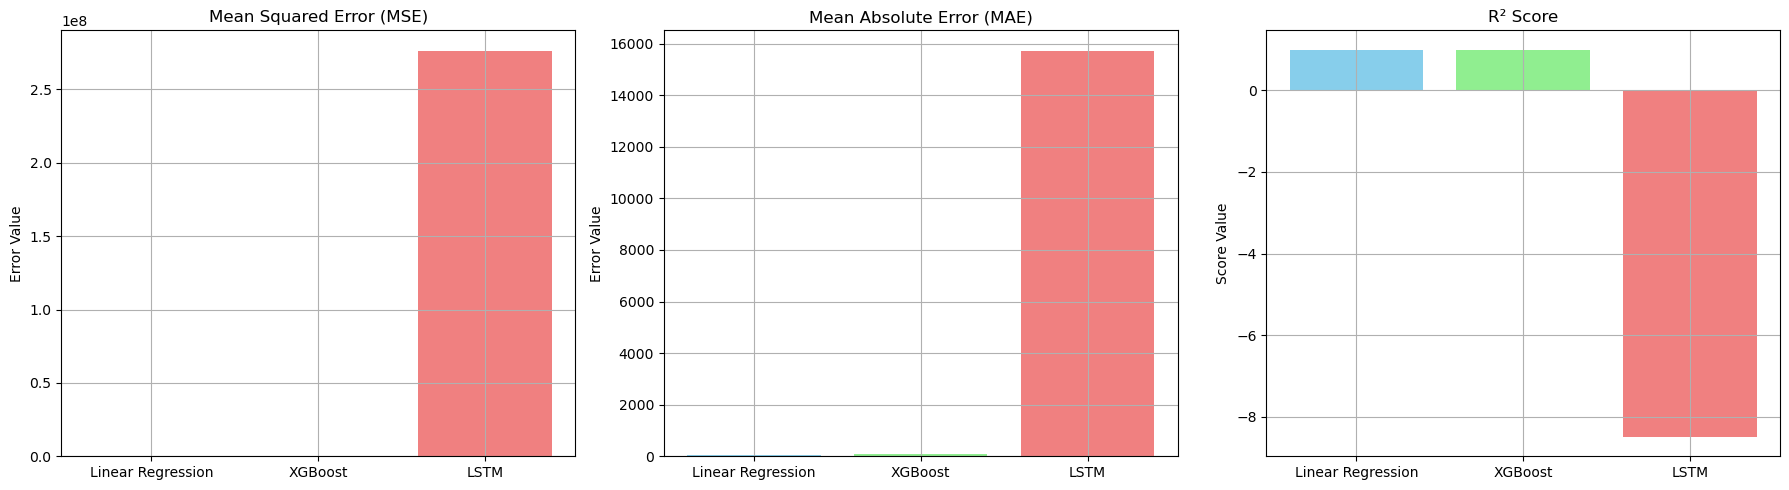

In [20]:
import matplotlib.pyplot as plt
import numpy as np

#  Actual vs Predicted Plot Function
def plot_actual_vs_predicted(y_test, preds, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, preds, color='blue', label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Perfect Fit')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.show()

#  Model Performance Comparison Plot
def plot_model_comparison():
    models = ['Linear Regression', 'XGBoost', 'LSTM']
    mse = [mse_lr, mse_xgb, mse_lstm]
    mae = [mae_lr, mae_xgb, mae_lstm]
    r2 = [r2_lr, r2_xgb, r2_lstm]

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # MSE Plot
    axs[0].bar(models, mse, color=['skyblue', 'lightgreen', 'lightcoral'])
    axs[0].set_title('Mean Squared Error (MSE)')
    axs[0].set_ylabel('Error Value')
    axs[0].grid(True)

    # MAE Plot
    axs[1].bar(models, mae, color=['skyblue', 'lightgreen', 'lightcoral'])
    axs[1].set_title('Mean Absolute Error (MAE)')
    axs[1].set_ylabel('Error Value')
    axs[1].grid(True)

    # R² Score Plot
    axs[2].bar(models, r2, color=['skyblue', 'lightgreen', 'lightcoral'])
    axs[2].set_title('R² Score')
    axs[2].set_ylabel('Score Value')
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

#  Plot actual vs predicted values for each model
plot_actual_vs_predicted(y_test, y_pred_lr, "Linear Regression")
plot_actual_vs_predicted(y_test, y_pred_xgb, "XGBoost")
plot_actual_vs_predicted(y_test, y_pred_lstm, "LSTM")

#  Model Comparison Graph
plot_model_comparison()



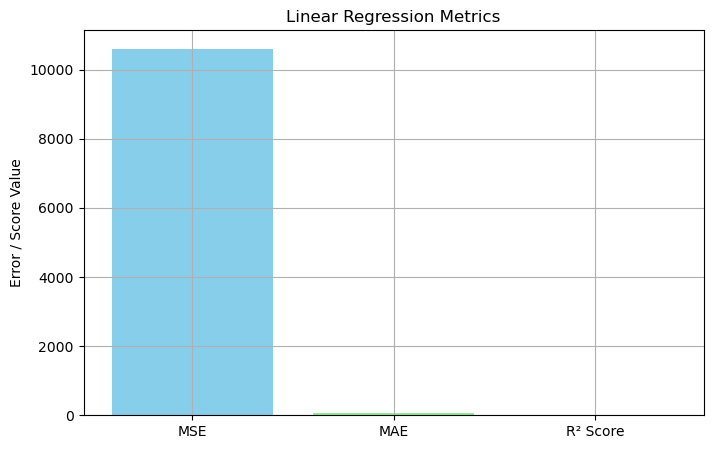

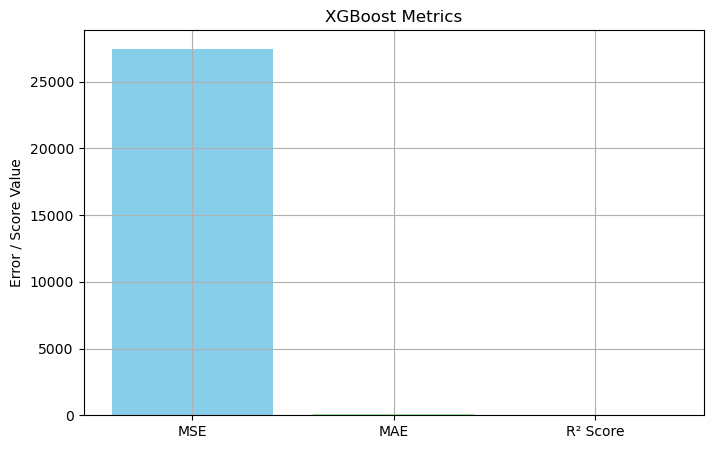

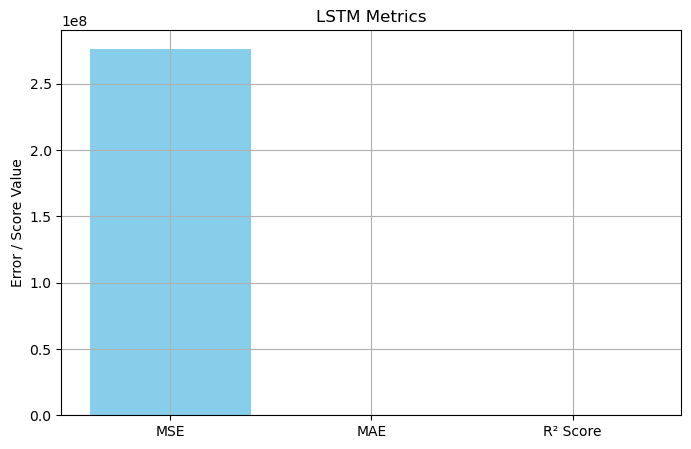

In [18]:
# 📊 Separate Model Performance Plots
def plot_individual_metrics(model_name, mse, mae, r2):
    metrics = ['MSE', 'MAE', 'R² Score']
    values = [mse, mae, r2]
    
    plt.figure(figsize=(8, 5))
    plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'lightcoral'])
    plt.title(f'{model_name} Metrics')
    plt.ylabel('Error / Score Value')
    plt.grid(True)
    plt.show()

# 📈 Plot individual metrics for each model
plot_individual_metrics('Linear Regression', mse_lr, mae_lr, r2_lr)
plot_individual_metrics('XGBoost', mse_xgb, mae_xgb, r2_xgb)
plot_individual_metrics('LSTM', mse_lstm, mae_lstm, r2_lstm)
